
![Py4Eng](img/logo.png)

# Optimization
## Yoav Ram

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize as opt
import scipy.special as spec
import seaborn as sns
sns.set(
    style='ticks',
    context='talk'
)
print('NumPy version:', np.__version__)
print('SciPy version:', scipy.__version__)

NumPy version: 1.10.4
SciPy version: 0.17.0


# Optimization

*Scipy* has several methods for optimizing (minimizing or maximizing) functions.

This session is roughly based on [Tutorial on "Modern Optimization Methods in Python" ](https://github.com/mmckerns/tutmom/blob/aae5de033cbbf7565f196fc8e92181fe0bbe9926/intro.ipynb).

## Simple minimization

Consider the following polynomial, defined using `np.poly1d1`, which, given the polynomial coeffcients $a_i$ returns a polynomial $\sum_{i=0}^n{a_i x^i}$:

In [2]:
p = np.poly1d((1.3, 4, 0.6))
print(p)

     2
1.3 x + 4 x + 0.6


In [3]:
def minplot(x, f, xmin=None):
    plt.plot(x, f(x))
    if xmin is not None:
        plt.plot(xmin, f(xmin), 'ok')
        plt.axvline(xmin, color='k', ls='--')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    sns.despine()
x = np.linspace(-10, 7)
minplot(x, p)

NameError: name 'p' is not defined

We'll use `scipy.optimize.fmin` (aliasing `scipy.optimize` as `opt`) to find a minimum for `p`, our polynomial. `fmin` uses the *downhill simplex algorithm* and we start with the guess 3:

Optimization terminated successfully.
         Current function value: -2.476923
         Iterations: 20
         Function evaluations: 40
x = [-1.53845215], p(x) = [-2.47692308]


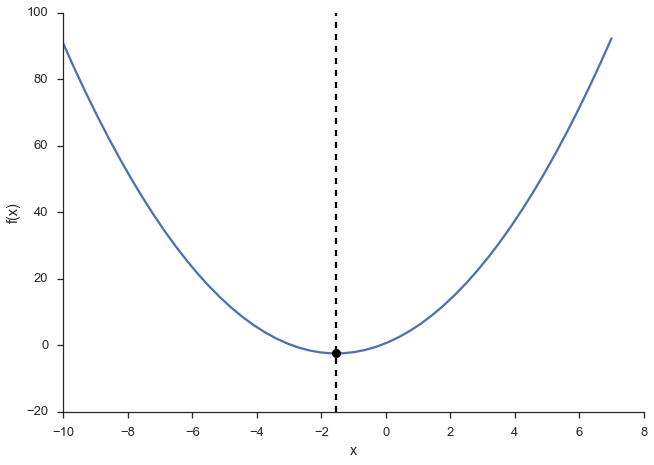

In [4]:
xmin = opt.fmin(p, [3])
print("x = {0}, p(x) = {1}".format(xmin, p(xmin)))
minplot(x, p, xmin)

## Exercise

Find the minimum of the function $f(x) = (x-2)*(x+1)^2$ using either `fmin` or `minimize_scalar`. The later doesn't require a guess (`x0`).

## Minimizing with "box" constraints

Suppose we want to find the minimum of a 1st order Bessel function with the constraint $2<x<4$:

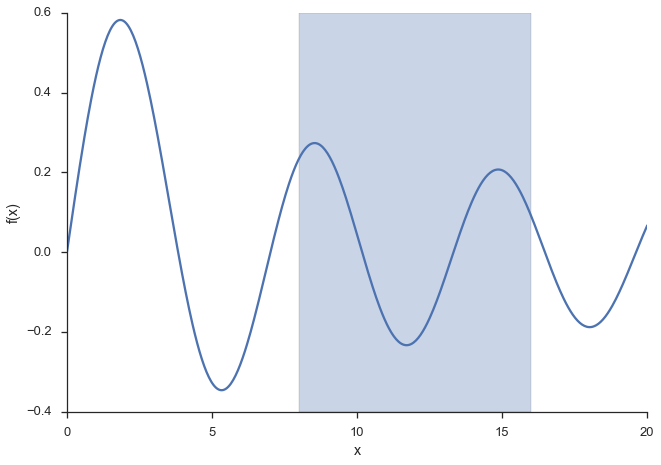

In [4]:
x = np.linspace(0, 20, 500)
minplot(x, spec.j1)
plt.axvspan(8, 16, alpha=0.3);

We use `opt.minimize_scalar` and give it constraints:

     fun: -0.23330441717143405
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: 11.706004881285123


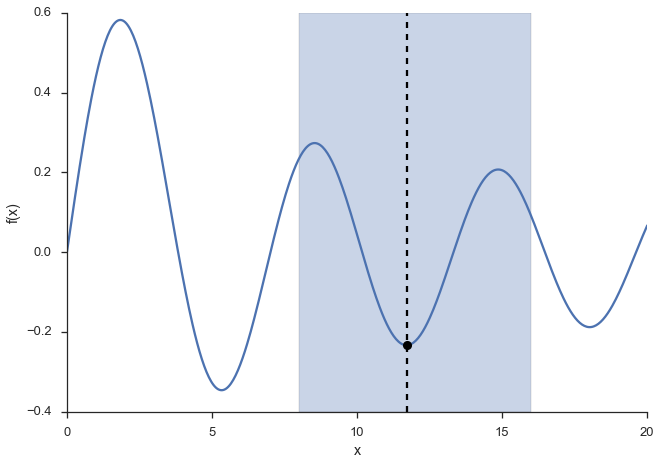

In [5]:
result = opt.minimize_scalar(spec.j1, method="bounded", bounds=[8, 16])
print(result)
minplot(x, spec.j1, result.x)
plt.axvspan(8, 16, alpha=0.3);

## Exercise

Find the **maximum** of the *Fresnel sin integral*, which is the first value returned from the $\mathbb R \to \mathbb R^2$ function [`scipy.special.fresnel`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.fresnel.html#scipy.special.fresnel). Constrain maximization to $x \in (2, 3)$. Plot the result and the maximum to make sure you got it right.

# Minimize a multivariate function

Follows example from [SciPy Tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#tutorial-sqlsp).

The `opt.minimize` provides interface to other contrained methods. Let's use *SLSQP* (Sequential Least SQuares Programming) method to deal with the following problem:

$$
f(x,y) = 2xy + 2x - x^2 -2y^2 \\
x^3 = y \\
y \ge 1
$$


In [7]:
def f(x, sign=1.0):
    return sign*(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)
x = np.linspace(-10, 10)
y = np.linspace(-10, 10)

The `%matplotlib notebook` is similar to the `inline` command only the figures will appear in a figure window (similar to MATLAB) rather than as an inline image. This will allow us to rotate and zoom 3D plots.

We load the `mplot3d` module that will allow us to do some 3D plotting.

In [8]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

In [9]:
def minplot3d(x, y, f, xmin=None, ymin=None):
    z = np.array([[f([xi, yi]) for yi in y] for xi in x])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, rstride=4, cstride=4, cmap='viridis', alpha=0.5)
    if xmin is not None and ymin is not None:
        ax.scatter3D(xmin, ymin, f([xmin, ymin]), s=50, c='k')

For this method we also need the derivative of `f` with respect to `x` and `y`:

In [10]:
def df(x, sign=1.0):
    dfdx0 = sign*(-2*x[0] + 2*x[1] + 2)
    dfdx1 = sign*(2*x[0] - 4*x[1])
    return np.array([ dfdx0, dfdx1 ])

<IPython.core.display.Javascript object>


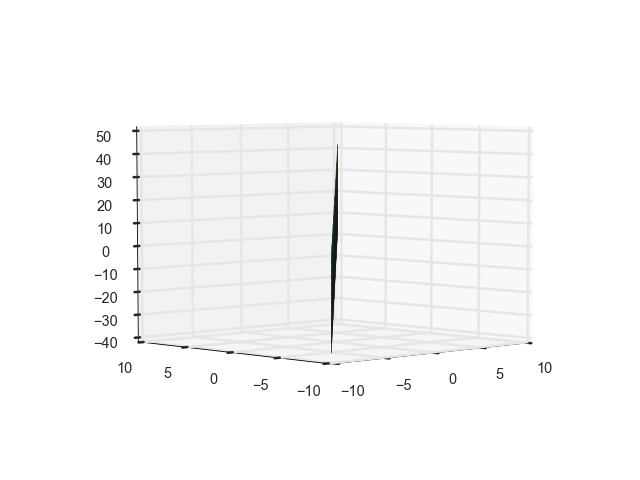

In [11]:
minplot3d(x, y, lambda x: df(x)[0])

<IPython.core.display.Javascript object>


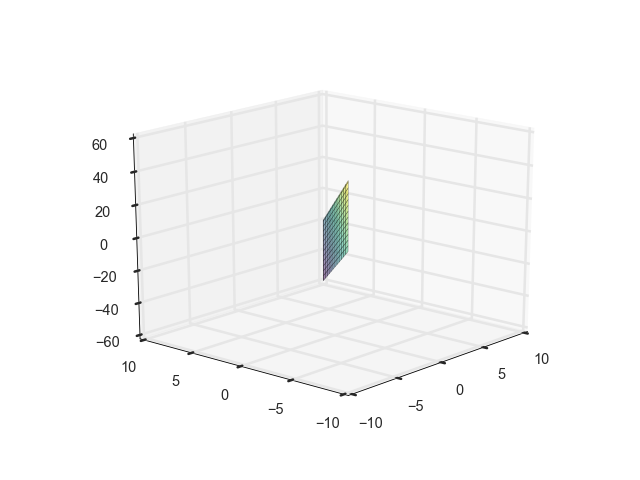

In [12]:
minplot3d(x, y, lambda x: df(x)[1])

Now an unconstrained optimization can be performed as:

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.0
            Iterations: 4
            Function evaluations: 5
            Gradient evaluations: 4
     fun: -1.9999999999999996
     jac: array([ -2.22044605e-16,  -0.00000000e+00,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 2.,  1.])
Min at  [ 2.  1.]


<IPython.core.display.Javascript object>


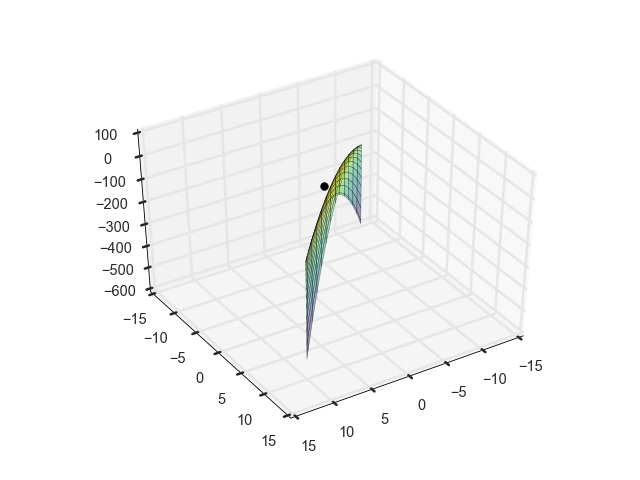

In [13]:
res = opt.minimize(
    f, 
    x0=[-1, 1],
    args=(-1.0,),
    jac=df,
    method='SLSQP', 
    options={'disp': True}
)
print(res)
print("Min at ", res.x)
xmin, ymin = res.x
minplot3d(x, y, f, xmin, ymin)

Then constraints are defined as a sequence of dictionaries, with keys `type`, `fun` and `jac`. Reminder:

$$
x^3 = y \Rightarrow x^3 - y = 0 \\
y \ge 1 \Rightarrow y - 1 \ge 0
$$

In [14]:
cons = (
    {
        'type': 'eq',
        'fun' : lambda v: np.array([v[0]**3 - v[1]]),
        'jac' : lambda v: np.array([3 * (v[0]**2), -1])
    },
    {
        'type': 'ineq',
        'fun' : lambda v: np.array([v[1] - 1]),
        'jac' : lambda v: np.array([0, 1])
    }
)

In [15]:
res = opt.minimize(
    f, 
    x0=[-1, 1],
    args=(-1.0,),
    jac=df,
    constraints=cons,
    method='SLSQP', 
    options={'disp': True}
)
print(res)
print()
print("Min at ", res.x)
xmin, ymin = res.x
print(xmin**3 - ymin)
print(ymin  - 1)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.00000018311
            Iterations: 9
            Function evaluations: 14
            Gradient evaluations: 9
     fun: -1.0000001831052137
     jac: array([-1.99999982,  1.99999982,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 14
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 1.00000009,  1.        ])

Min at  [ 1.00000009  1.        ]
2.74657858235e-07
0.0


<IPython.core.display.Javascript object>


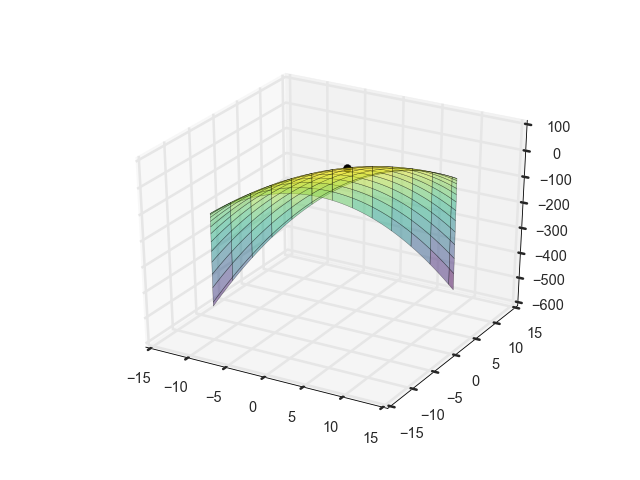

In [83]:
minplot3d(x, y, f, xmin, ymin)

## Exercise

Minimize the Rosenbrock function:
$$
f(x) = \sum_{i=1}^{N-1}{100(x_i -X{i-1}^2)^2 + (1-x_{i-1})^2}
$$
defined in `opt.rosen` as a function that accepts an array `x`.

Use how many dimensions you want (determined by the initial guess), use the function `opt.minimize` with `method` set to either `nelder-mead` or `powell`.

The result should be an array of `1`s. If you get something close but not quite, you can change the tolerance by giving `opt.minimize` the argument `options={'xtol':tol}`, where `tol` is the error tolerance you want.

# References

- [`scipy.optimize` tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#univariate-function-minimizers-minimize-scalar)

## Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the _Python for Engineers_ course.

The notebook was written using [Python](http://pytho.org/) 3.4.4, [IPython](http://ipython.org/) 4.0.3 and [Jupyter](http://jupyter.org) 4.0.6.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)